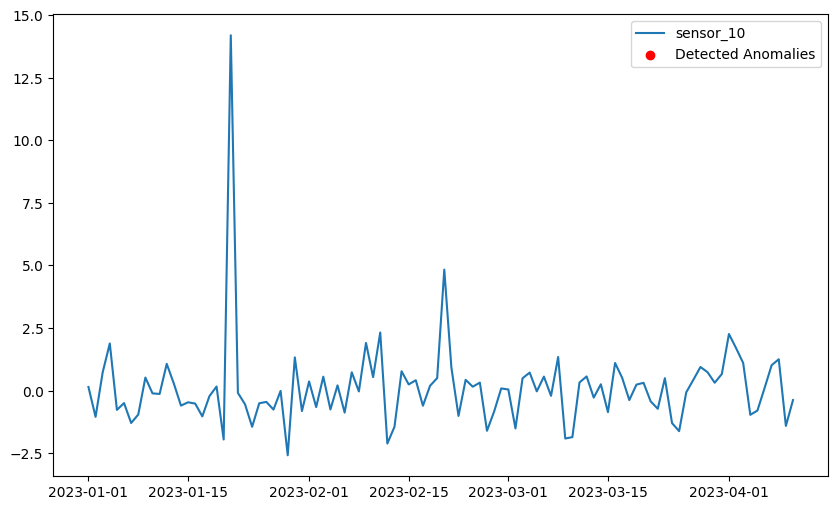

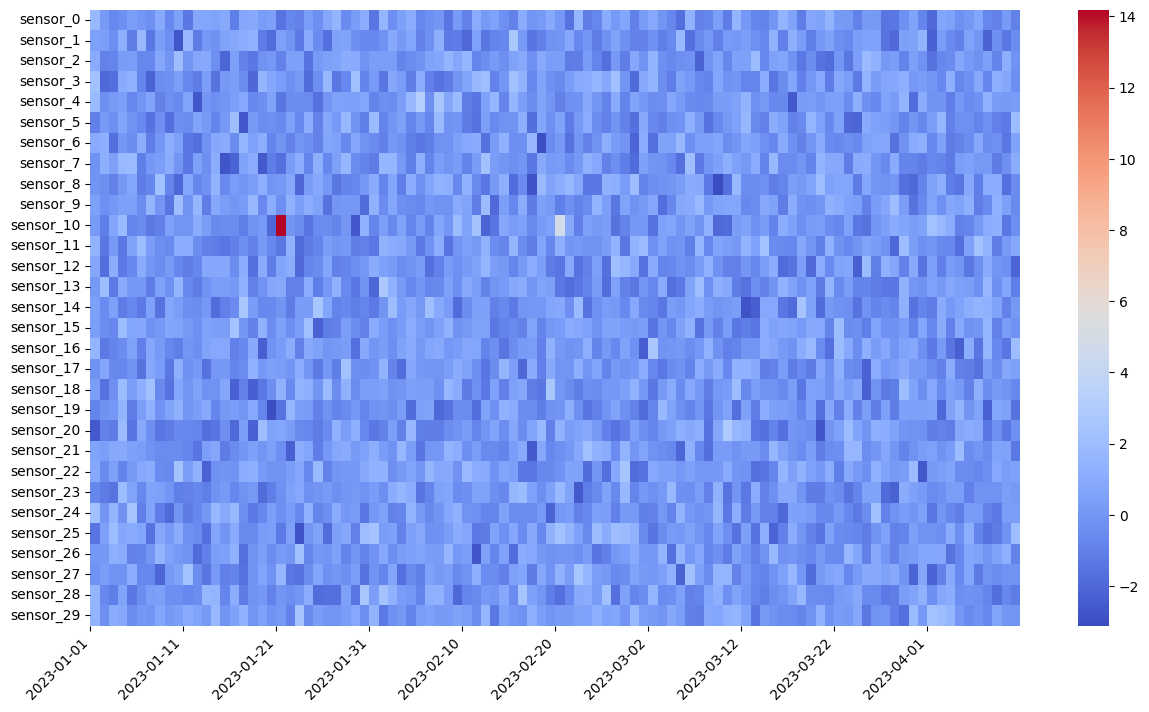

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 시드 설정
np.random.seed(0)

# 시계열 데이터 생성 (100개의 변수를 가진 100개의 타임스텝)
timesteps = 100
features = 30
data = np.random.randn(timesteps, features)

# 데이터프레임 생성
columns = [f"sensor_{i}" for i in range(features)]
df = pd.DataFrame(data, columns=columns)
df.index = pd.date_range("2023-01-01", periods=timesteps, freq='D')

# 이상치 추가할 특징
anomaly_feature = ["sensor_10"]

# 이상치 추가
anomaly_timesteps = [20, 50, 70, 90]
for anomaly in anomaly_timesteps:
    df.loc[df.index[anomaly], anomaly_feature] = df.loc[df.index[anomaly], anomaly_feature] + np.random.randn() * 10

# StandardScaler를 사용한 z-스코어 기반 이상치 감지
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 관심 있는 특징의 z-스코어 연산
z_scores = np.abs(scaled_data[:, 0]) # feature_0에 대한 z-스코어
threshold = 3  # z-스코어 threshold 설정
anomalies = np.where(z_scores > threshold)

# 이상치 인덱스로 변환
anomaly_indices = np.unique(anomalies)

# 시계열 데이터 시각화 (특정 특징에 대해)
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[anomaly_feature], label=anomaly_feature)
plt.scatter(df.index[anomaly_indices], df.iloc[anomaly_indices][anomaly_feature], color='red', label='Detected Anomalies', zorder=5)
# plt.title(f"Detected Anomalies in {anomaly_feature}")
# plt.xlabel("Date")
# plt.ylabel(anomaly_feature)
plt.legend()
plt.show()

# Heatmap visualization
plt.figure(figsize=(15, 8))
sns.heatmap(df.T, cmap='coolwarm', cbar=True)
# plt.title("Heatmap of Multivariate Time Series Data")
# plt.xlabel("Time")
# plt.ylabel("Features")

# x축 레이블을 보기 좋게 변경
plt.xticks(ticks=np.arange(0, timesteps, step=10), labels=df.index.strftime('%Y-%m-%d')[::10], rotation=45, ha='right')
plt.show()

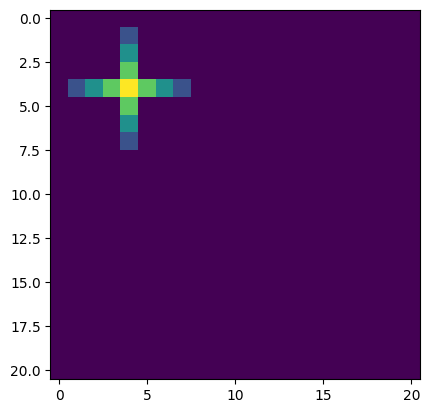

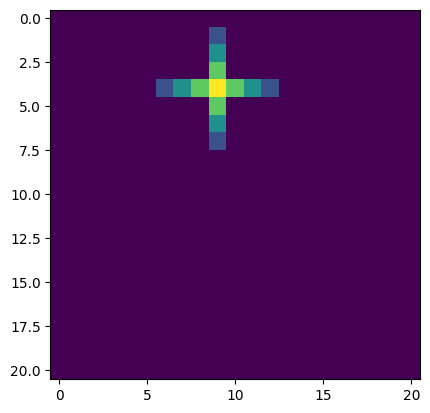

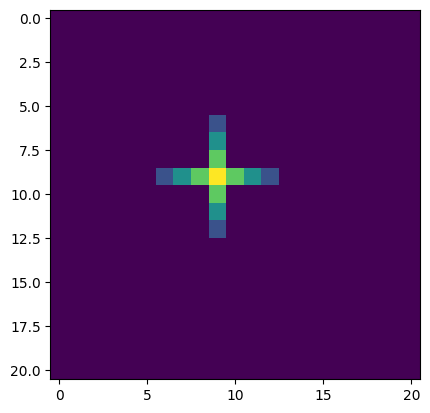

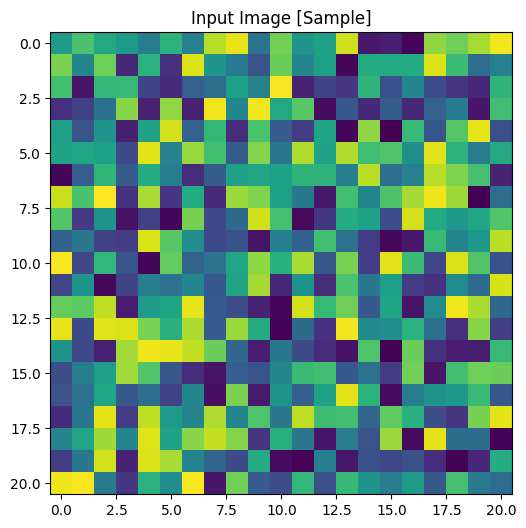

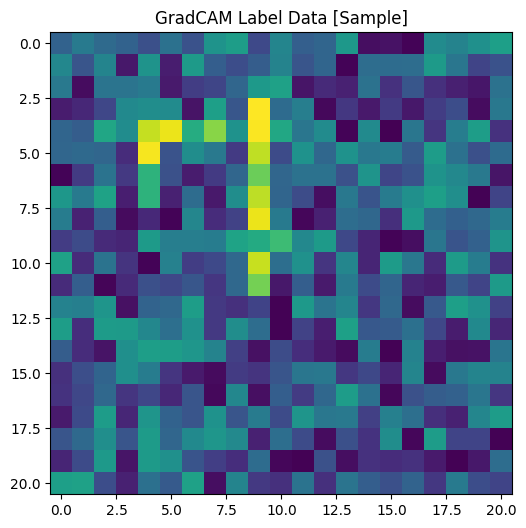

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_cross_mask(shape, center, length):
    """
    십자가 모양의 마스크를 생성한다 (중심에서 멀어질수록 약하게 강조)
    
    Args:
    - shape (tuple): 마스크의 크기 (height, width)
    - center (tuple): 십자가 중심의 (row, col) 위치
    - length (int): 십자가의 팔 길이
    
    Returns:
    - mask (numpy.ndarray): 십자가 모양의 강조 마스크
    """
    height, width = shape
    center_row, center_col = center
    mask = np.zeros((height, width))
    
    for r in range(max(center_row - length, 0), min(center_row + length + 1, height)):
        distance = abs(center_row - r)
        intensity = 1 - (distance / length)
        mask[r, center_col] = intensity
    
    for c in range(max(center_col - length, 0), min(center_col + length + 1, width)):
        distance = abs(center_col - c)
        intensity = 1 - (distance / length)
        mask[center_row, c] = intensity
    
    return mask

def generate_gradcam_labels(input_images, highlight_positions, cross_length=4):
    """
    입력 이미지를 받아 특정 위치에 십자가 모양으로 강조한 이미지를 생성하는 함수.
    
    Args:
    - input_images (numpy.ndarray): (1000, 21, 21) shape의 입력 이미지
    - highlight_positions (list): 강조할 위치 (row, col)의 리스트
    - cross_length (int): 십자가의 팔 길이
    
    Returns:
    - output_images (numpy.ndarray): 강조된 부분이 있는 이미지들과 동일한 shape
    """
    output_images = input_images.copy()
    height, width = input_images.shape[1], input_images.shape[2]
    
    for img in output_images:
        for center in highlight_positions:
            mask = generate_cross_mask((height, width), center, cross_length)
            img += mask  # 강조 마스크를 이미지에 추가

    return output_images

# 예제 입력 이미지 생성 (1000, 21, 21 랜덤 데이터)
np.random.seed(0)
input_images = np.random.rand(1, 21, 21)

# 강조할 위치 리스트
highlight_positions = [(4, 4), (4, 9), (9, 9)]

# GradCAM Label 데이터 생성
gradcam_labels = generate_gradcam_labels(input_images, highlight_positions, cross_length=4)

# 첫 번째 이미지 (입력 데이터 중 하나) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(input_images[0])
plt.title("Input Image [Sample]")
plt.show()

# 첫 번째 이미지 (GradCAM Label 데이터 중 하나) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(gradcam_labels[0])
plt.title("GradCAM Label Data [Sample]")
plt.show()

In [1]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_cams(pred_cams, true_labels, threshold=0.5):
    """
    Evaluates the predicted CAMs against the true labels using Precision, Recall, and F1-score.
    
    Args:
    - pred_cams (torch.Tensor or np.ndarray): Predicted CAMs, shape (batch_size, 21, 21)
    - true_labels (torch.Tensor or np.ndarray): Ground truth labels, shape (batch_size, 21, 21)
    - threshold (float): Threshold to binarize the predicted CAMs

    Returns:
    - precision (float): Precision score
    - recall (float): Recall score
    - f1 (float): F1-score
    """
    # Ensure inputs are numpy arrays
    if isinstance(pred_cams, torch.Tensor):
        pred_cams = pred_cams.detach().cpu().numpy()
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.detach().cpu().numpy()

    # Binarize predicted CAMs based on the threshold
    bin_pred_cams = (pred_cams >= threshold).astype(int)

    # Flatten the arrays
    bin_pred_cams_flat = bin_pred_cams.flatten()
    true_labels_flat = true_labels.flatten()

    # Calculate precision, recall, and F1-score
    precision = precision_score(true_labels_flat, bin_pred_cams_flat, average='binary')
    recall = recall_score(true_labels_flat, bin_pred_cams_flat, average='binary')
    f1 = f1_score(true_labels_flat, bin_pred_cams_flat, average='binary')

    return precision, recall, f1

# Example usage assuming cam_pred and cam_true are your batch of predicted and true CAMs
# cam_pred: (batch_size, 21, 21) - Model outputs
# cam_true: (batch_size, 21, 21) - Ground truth labels

batch_size = 16  # Example batch size
cam_pred = torch.rand((batch_size, 21, 21))  # Example predicted CAMs
cam_true = torch.randint(0, 2, (batch_size, 21, 21))  # Example true labels

precision, recall, f1 = evaluate_cams(cam_pred, cam_true, threshold=0.5)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.5014
Recall: 0.5061
F1-score: 0.5037


In [5]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_weighted_metrics(pred_cams, true_labels):
    """
    Evaluates the predicted CAMs against the true labels using weighted Precision, Recall, and F1-score.
    
    Args:
    - pred_cams (torch.Tensor or np.ndarray): Predicted CAMs, shape (batch_size, 21, 21)
    - true_labels (torch.Tensor or np.ndarray): Ground truth labels, shape (batch_size, 21, 21)

    Returns:
    - precision (float): Weighted Precision score
    - recall (float): Weighted Recall score
    - f1 (float): Weighted F1-score
    """
    # Ensure inputs are numpy arrays
    if isinstance(pred_cams, torch.Tensor):
        pred_cams = pred_cams.detach().cpu().numpy()
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.detach().cpu().numpy()

    # Flatten the arrays
    pred_cams_flat = pred_cams.flatten()
    true_labels_flat = true_labels.flatten()

    # Weights can be the true label values or any other relevant scores.
    weights = true_labels_flat

    # Calculate weighted precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, (pred_cams_flat > 0.5).astype(int), average='weighted', sample_weight=weights)

    return precision, recall, f1

# Example usage assuming cam_pred and cam_true are your batch of predicted and true CAMs
cam_pred = torch.rand((batch_size, 21, 21))  # Example predicted CAMs
cam_true = torch.rand((batch_size, 21, 21))  # Example true labels containing severity scores

precision, recall, f1 = evaluate_weighted_metrics(cam_pred, cam_true)
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1-score: {f1:.4f}')

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [8]:
import torch
import numpy as np

def min_max_normalize(tensor, is_tensor=True, handle_all_zero=True):
    eps = np.finfo(float).eps  # Very small value
    if is_tensor:
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        
        if max_val == 0:
            # Handle the case where max value is zero
            if handle_all_zero:
                return torch.zeros_like(tensor)  # Set all values to 0
            else:
                return tensor  # Do not normalize, return as is
        
        normalized_tensor = (tensor - min_val) / (max_val - min_val + eps)
    else:
        min_val = np.min(tensor)
        max_val = np.max(tensor)
        
        if max_val == 0:
            # Handle the case where max value is zero
            if handle_all_zero:
                return np.zeros_like(tensor)  # Set all values to 0
            else:
                return tensor  # Do not normalize, return as is
        
        normalized_tensor = (tensor - min_val) / (max_val - min_val + eps)
    return normalized_tensor

# Example usage with PyTorch tensor
tensor = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
tensor_zero_max = torch.tensor([-2.0, -1.0, 0.0, 0.0, 0.0])
normalized_tensor = min_max_normalize(tensor, is_tensor=True)
normalized_tensor_zero_max = min_max_normalize(tensor_zero_max, is_tensor=True)
print(normalized_tensor)
print(normalized_tensor_zero_max)

# Example usage with NumPy array
array = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
array_zero_max = np.array([-2.0, -1.0, 0.0, 0.0, 0.0])
normalized_array = min_max_normalize(array, is_tensor=False)
normalized_array_zero_max = min_max_normalize(array_zero_max, is_tensor=False)
print(normalized_array)
print(normalized_array_zero_max)

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
tensor([0., 0., 0., 0., 0.])
[0.   0.25 0.5  0.75 1.  ]
[0. 0. 0. 0. 0.]


In [1]:
import torch
import numpy as np

# 예시 입력 데이터
data = [
    np.array([11, 16]), np.array([5, 1]), np.array([6, 14]), np.array([17, 20, 11]), np.array([13, 19]), np.array([4]), 
    np.array([16]), np.array([12]), np.array([6]), np.array([20, 16]), np.array([9]), np.array([12]), np.array([13, 5]), 
    np.array([10, 6]), np.array([4, 19]), np.array([0, 18, 9]), np.array([16, 11]), np.array([16, 12]), np.array([14, 11]), 
    np.array([18, 7]), np.array([16, 0, 5]), np.array([1, 8, 19]), np.array([7, 2, 1]), np.array([18]), np.array([4, 10]), 
    np.array([6]), np.array([18]), np.array([1]), np.array([12, 1]), np.array([19, 8, 11]), np.array([19]), np.array([1, 15]), 
    np.array([7]), np.array([0]), np.array([17]), np.array([8, 19]), np.array([1, 14, 16]), np.array([6, 13]), np.array([10]), 
    np.array([12, 5, 15]), np.array([20, 17]), np.array([3, 12]), np.array([9, 6, 17]), np.array([16, 3]), np.array([8, 18]), 
    np.array([2]), np.array([4, 13]), np.array([12, 16, 17]), np.array([11, 13]), np.array([13]), [-1], [-1], [-1], [-1], 
    [-1], [-1], [-1], [-1], [-1], [-1], # 이후 -1로 패딩된 나머지 요소들
]

# 배열 요소들을 길이 4로 패딩
max_len = 4
padded_data = []
for arr in data:
    arr = np.array(arr)  # 확실히 numpy 배열로 전환
    padded_arr = np.pad(arr, (0, max_len - len(arr)), constant_values=-1)
    padded_data.append(padded_arr)

# 패딩된 데이터를 텐서로 변환
tensor_data = torch.tensor(padded_data)

# 원하는 형태로 변환되었는지 출력 확인
print(tensor_data.shape)  # (100, 4)를 기대
print(tensor_data)

torch.Size([60, 4])
tensor([[11, 16, -1, -1],
        [ 5,  1, -1, -1],
        [ 6, 14, -1, -1],
        [17, 20, 11, -1],
        [13, 19, -1, -1],
        [ 4, -1, -1, -1],
        [16, -1, -1, -1],
        [12, -1, -1, -1],
        [ 6, -1, -1, -1],
        [20, 16, -1, -1],
        [ 9, -1, -1, -1],
        [12, -1, -1, -1],
        [13,  5, -1, -1],
        [10,  6, -1, -1],
        [ 4, 19, -1, -1],
        [ 0, 18,  9, -1],
        [16, 11, -1, -1],
        [16, 12, -1, -1],
        [14, 11, -1, -1],
        [18,  7, -1, -1],
        [16,  0,  5, -1],
        [ 1,  8, 19, -1],
        [ 7,  2,  1, -1],
        [18, -1, -1, -1],
        [ 4, 10, -1, -1],
        [ 6, -1, -1, -1],
        [18, -1, -1, -1],
        [ 1, -1, -1, -1],
        [12,  1, -1, -1],
        [19,  8, 11, -1],
        [19, -1, -1, -1],
        [ 1, 15, -1, -1],
        [ 7, -1, -1, -1],
        [ 0, -1, -1, -1],
        [17, -1, -1, -1],
        [ 8, 19, -1, -1],
        [ 1, 14, 16, -1],
        [ 6, 13, -

/tmp/ipykernel_2146180/1667754558.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  tensor_data = torch.tensor(padded_data)


In [4]:
import torch

def transform_data(input_data):
    """
    주어진 데이터를 변환하여 [a, e], [b, e], [c, e], [d, e] 꼴의 데이터를 반환합니다.
    이때, a, b, c, d가 -1일 경우 해당 데이터는 제외합니다.
    
    Args:
        input_data (list of tuples): 각 요소는 ([a, b, c, d], e) 형식의 튜플입니다.
    
    Returns:
        torch.Tensor: 변환된 데이터를 포함하는 텐서
    """
    transformed_data = []

    for data_pair in input_data:
        data_array, e = data_pair
        # -1인 값은 제외하고 (텐서, e) 쌍을 만듬
        for element in data_array:
            if element != -1:
                transformed_data.append((element, e))

    # (가) [(a, e), (b, e)...] 형태를 [a, e], [b, e], [c, e], ... 형태로 변환합니다.
    transformed_tensor = torch.stack([torch.stack(pair) for pair in transformed_data])

    return transformed_tensor

# 예시 입력 데이터
input_data = [
    (torch.tensor([5, 15, 4, -1]), torch.tensor(19)),
    (torch.tensor([10, -1, -1, -1]), torch.tensor(6)),
    (torch.tensor([17, 18, -1, -1]), torch.tensor(16)),
    (torch.tensor([17, 1, 13, -1]), torch.tensor(6)),
    (torch.tensor([17, -1, -1, -1]), torch.tensor(6)),
    # 필요시 여기서 더 많은 데이터 추가
]

# 함수 호출
transformed_tensor = transform_data(input_data)

# 원하는 형태의 텐서로 변환되었는지 출력 확인
print(transformed_tensor.shape)  # 전환된 텐서의 크기 확인
print(transformed_tensor)

torch.Size([10, 2])
tensor([[ 5, 19],
        [15, 19],
        [ 4, 19],
        [10,  6],
        [17, 16],
        [18, 16],
        [17,  6],
        [ 1,  6],
        [13,  6],
        [17,  6]])


In [20]:
a, b = transformed_tensor[0]
a


tensor(5)

In [6]:
def min_max_normalize(array, is_tensor=True):
    eps = np.finfo(float).eps  # 아주 작은 값

    if is_tensor:
        if array.dim() == 3:  # (1000, 21, 21)
            min_val = torch.amin(array, dim=(1, 2), keepdim=True)
            max_val = torch.amax(array, dim=(1, 2), keepdim=True)
        elif array.dim() == 4:  # (batch, channels, height, width)
            min_val = torch.amin(array, dim=(2, 3), keepdim=True)
            max_val = torch.amax(array, dim=(2, 3), keepdim=True)
        else:
            raise ValueError("Unexpected tensor shape. Expected a 3D or 4D tensor.")
        
        normalized_array = (array - min_val) / (max_val - min_val + eps)
    else:
        if array.ndim == 3:  # (1000, 21, 21)
            min_val = np.min(array, axis=(1, 2), keepdims=True)
            max_val = np.max(array, axis=(1, 2), keepdims=True)
        elif array.ndim == 4:  # (batch, channels, height, width)
            min_val = np.min(array, axis=(2, 3), keepdims=True)
            max_val = np.max(array, axis=(2, 3), keepdims=True)
        else:
            raise ValueError("Unexpected array shape. Expected a 3D or 4D array.")
        
        normalized_array = (array - min_val) / (max_val - min_val + eps)
        
    return normalized_array

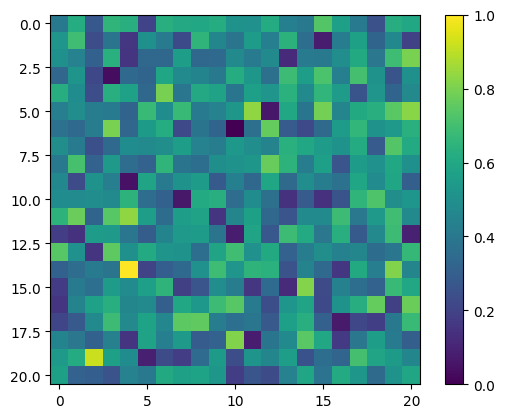

In [9]:
import numpy as np
import matplotlib.pyplot as plt

noise = np.random.randn(1, 21, 21)
noise = min_max_normalize(noise, False)
plt.imshow(noise.squeeze())
plt.colorbar()
plt.show()
